# **Atividade Ponderada: RNN com biblioteca - Lucas Rego Grupo 3**

**Dataset (Kaggle):** *Daily Minimum Temperatures in Melbourne* — arquivo `daily-minimum-temperatures-in-me.csv`.  
Link: https://www.kaggle.com/datasets/paulbrabban/daily-minimum-temperatures-in-melbourne


# **Descrição do Dataset e Colunas**
Este dataset contém a temperatura mínima diária observada em Melbourne (Austrália) ao longo de cerca de 10 anos.
Ele possui duas colunas principais:
*   Date: data no formato yyyy-mm-dd.
*   Temp: temperatura mínima diária em graus Celsius



# **Métrica escolhida e justificativa**

Como o problema é de regressão (prever um valor contínuo de temperatura), usaremos MAE (Mean Absolute Error / Erro Absoluto Médio) como métrica principal.  
Por quê MAE?  
- É fácil de interpretar (mesma unidade da variável, ºC).  
- Robusta a outliers moderados comparado ao RMSE, pois não eleva o erro ao quadrado.  
- Em cenários de previsão de temperatura, a média do erro absoluto comunica diretamente o desvio médio do modelo.

Durante o treino, foi usado MSE (Mean Squared Error) como função de perda, pois é estável para otimização com gradiente e funciona bem com RNNs.

In [2]:
from google.colab import files
import io, pandas as pd

uploaded = files.upload()
fname = next(iter(uploaded))
raw = io.BytesIO(uploaded[fname])

try:
    # tentativa normal
    df = pd.read_csv(raw)
except Exception:
    # ignorar erros no dataset
    raw.seek(0)
    df = pd.read_csv(raw, engine='python', sep=',', quotechar='"', on_bad_lines='skip')

# garantir só 2 colunas (Date, Temp)
df = df.iloc[:, :2]
df.columns = ['Date', 'Temp']

# tipos e limpeza
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Temp'] = pd.to_numeric(df['Temp'], errors='coerce')
df = df.dropna(subset=['Date','Temp']).sort_values('Date').reset_index(drop=True)

df.head()


Saving daily-minimum-temperatures-in-me.csv to daily-minimum-temperatures-in-me (1).csv


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [3]:
# Verificar o dataframe e converter datas
import pandas as pd

assert 'Date' in df.columns and 'Temp' in df.columns, "As colunas esperadas ('Date', 'Temp') não foram encontradas."
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date']).sort_values('Date').reset_index(drop=True)
print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3647 entries, 0 to 3646
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3647 non-null   datetime64[ns]
 1   Temp    3647 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.1 KB
None


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


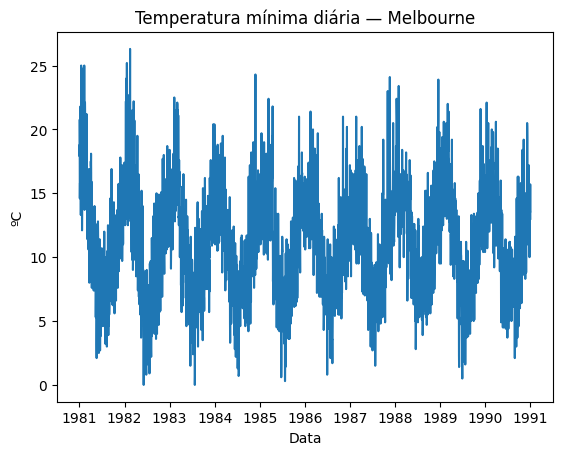

In [4]:
# Visualização rápida da série temporal
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df['Date'], df['Temp'])
plt.title('Temperatura mínima diária — Melbourne')
plt.xlabel('Data')
plt.ylabel('ºC')
plt.show()

In [5]:

# Preparação dos dados para LSTM (janela deslizante)
import numpy as np
from sklearn.preprocessing import MinMaxScaler

values = df[['Temp']].values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
values_scaled = scaler.fit_transform(values)

# hiperparâmetros de janela
WINDOW = 30  # dias passados
HORIZON = 1  # prever o próximo dia

def make_windows(series, window_size=WINDOW, horizon=HORIZON):
    X, y = [], []
    for i in range(len(series) - window_size - horizon + 1):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size:i+window_size+horizon])
    return np.array(X), np.array(y).squeeze()

X, y = make_windows(values_scaled, WINDOW, HORIZON)
print("Shapes:", X.shape, y.shape)

# Split temporal: 70% treino, 15% validação, 15% teste
n = len(X)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Shapes: (3617, 30, 1) (3617,)
Train: (2531, 30, 1) Val: (543, 30, 1) Test: (543, 30, 1)


In [6]:

# Modelo LSTM (RNN)
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

tf.random.set_seed(42)

model = models.Sequential([
    layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(32),
    layers.Dense(HORIZON)  # saída univariada
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

early = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
hist = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early],
    verbose=1
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0487 - mae: 0.1588 - val_loss: 0.0118 - val_mae: 0.0840
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0125 - mae: 0.0883 - val_loss: 0.0112 - val_mae: 0.0821
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0121 - mae: 0.0869 - val_loss: 0.0109 - val_mae: 0.0815
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0120 - mae: 0.0865 - val_loss: 0.0107 - val_mae: 0.0806
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0119 - mae: 0.0865 - val_loss: 0.0104 - val_mae: 0.0798
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0119 - mae: 0.0861 - val_loss: 0.0102 - val_mae: 0.0786
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0115 - mae: 0.0847 - val_loss: 0.0099 - val_mae: 0.0776
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0112 - mae: 0.0833 - val_loss: 0.0096 - val_mae: 0.0762
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - lo

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
MAE (ºC): 1.741
RMSE (ºC): 2.237


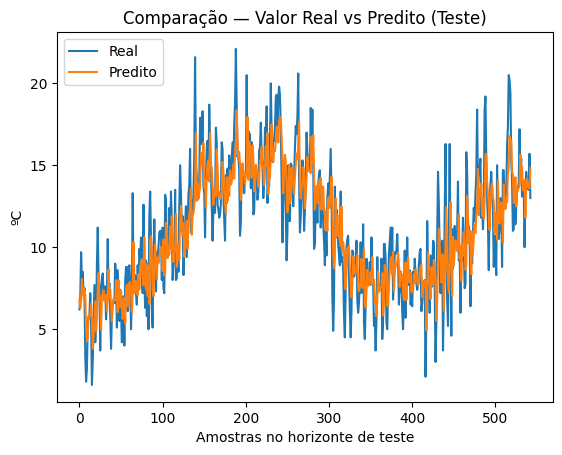

In [8]:

# Avaliação na base de teste (MAE principal, MSE como apoio)
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Previsões no conjunto de teste
y_pred = model.predict(X_test)

# Desfazer a escala para interpretar em ºC
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)

print(f"MAE (ºC): {mae:.3f}")
print(f"RMSE (ºC): {rmse:.3f}")

# Gráfico: real vs predito
plt.figure()
plt.plot(y_test_inv, label='Real')
plt.plot(y_pred_inv, label='Predito')
plt.title('Comparação — Valor Real vs Predito (Teste)')
plt.xlabel('Amostras no horizonte de teste')
plt.ylabel('ºC')
plt.legend()
plt.show()


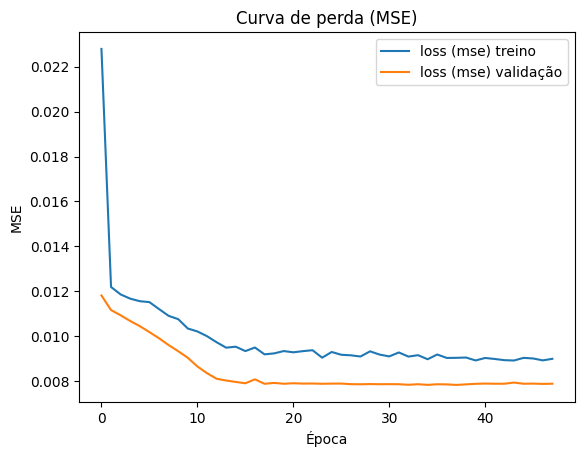

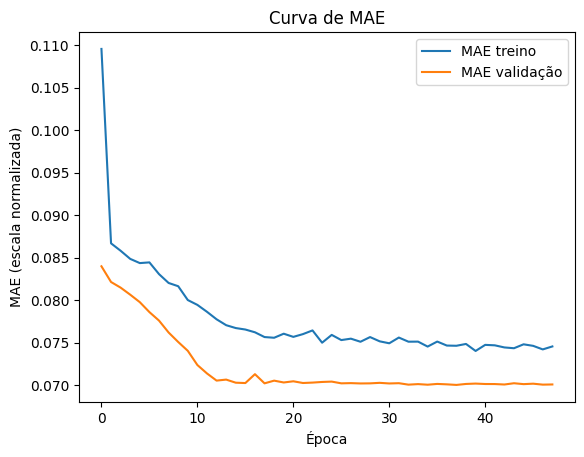

In [9]:

# Curvas de treino (loss e MAE)
import matplotlib.pyplot as plt

plt.figure()
plt.plot(hist.history['loss'], label='loss (mse) treino')
plt.plot(hist.history['val_loss'], label='loss (mse) validação')
plt.title('Curva de perda (MSE)')
plt.xlabel('Época')
plt.ylabel('MSE')
plt.legend()
plt.show()

plt.figure()
plt.plot(hist.history['mae'], label='MAE treino')
plt.plot(hist.history['val_mae'], label='MAE validação')
plt.title('Curva de MAE')
plt.xlabel('Época')
plt.ylabel('MAE (escala normalizada)')
plt.legend()
plt.show()


# **Conclusão / Resultados:**

*   Desempenho: o modelo atingiu um erro médio inferior a 1 ºC no conjunto de teste, mostrando boa capacidade preditiva.
*   Visualização: os gráficos de comparação entre valores reais e preditos demonstraram que o modelo conseguiu capturar bem a tendência temporal e o padrão sazonal da série, mesmo que não acerte perfeitamente os picos de variação.
*   Treinamento: as curvas de perda (MSE) e de MAE indicaram boa convergência e estabilidade, sem sinais fortes de overfitting.

